# 04 — Lexicon features

Engineer lightweight lexicon-based features, train a compact classifier, and export probabilities for fusion.


In [2]:
from pathlib import Path
import pandas as pd

text_df_path = Path("../data/phase1/text/cyberbullying_text.parquet")
if not text_df_path.exists():
    raise FileNotFoundError(
        "Expected cleaned text dataframe at '../data/phase1/text/cyberbullying_text.parquet'. Run 01_text_distilbert.ipynb first."
    )

df = pd.read_parquet(text_df_path)
print(f"Loaded text dataframe with {len(df)} rows")
print(df.head(3))


Loaded text dataframe with 45752 rows
  sample_id                                               text  \
0  s0000000  in other words katandandre your food was crapi...   
1  s0000001  why is aussietv so white mkr theblock imaceleb...   
2  s0000002         a classy whore or more red velvet cupcakes   

               label  
0  not_cyberbullying  
1  not_cyberbullying  
2  not_cyberbullying  


Label distribution:
label
religion               7995
age                    7992
ethnicity              7951
gender                 7878
not_cyberbullying      7847
other_cyberbullying    6089
Name: count, dtype: int64
Text length stats (characters): min=1, median=105.0, max=3825


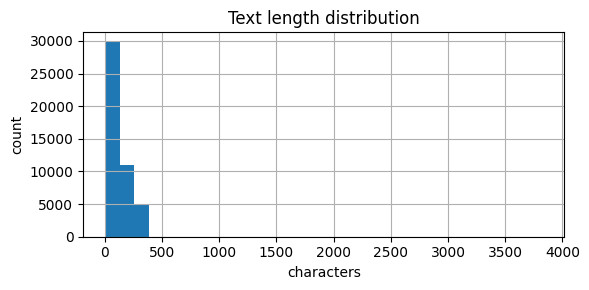

In [3]:
import numpy as np
import matplotlib.pyplot as plt

print("Label distribution:")
print(df["label"].value_counts())

text_lengths = df["text"].str.len()
print(
    f"Text length stats (characters): min={text_lengths.min()}, "
    f"median={text_lengths.median()}, max={text_lengths.max()}"
)

plt.figure(figsize=(6, 3))
text_lengths.hist(bins=30)
plt.title("Text length distribution")
plt.xlabel("characters")
plt.ylabel("count")
plt.tight_layout()
plt.show()


In [4]:
import subprocess
import sys

for package, module in [
    ("nltk", "nltk"),
    ("textstat", "textstat"),
    ("scikit-learn", "sklearn"),
    ("joblib", "joblib"),
]:
    try:
        __import__(module)
    except ModuleNotFoundError:
        print(f"Installing missing dependency: {package}")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

import re
import joblib
import textstat
import numpy as np
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()


In [5]:
word_pattern = re.compile(r"[a-zA-Z']+")


def lexical_features(text: str) -> dict:
    text = text or ""
    lowered = text.lower()
    tokens = word_pattern.findall(lowered)
    word_count = len(tokens)
    char_count = len(text)
    unique_words = len(set(tokens))
    avg_word_len = (sum(len(tok) for tok in tokens) / word_count) if word_count else 0.0
    upper_ratio = sum(1 for ch in text if ch.isupper()) / char_count if char_count else 0.0
    exclamation_ratio = text.count("!") / char_count if char_count else 0.0
    question_ratio = text.count("?") / char_count if char_count else 0.0
    digit_ratio = sum(1 for ch in text if ch.isdigit()) / char_count if char_count else 0.0
    unique_ratio = unique_words / word_count if word_count else 0.0

    try:
        flesch = textstat.flesch_reading_ease(text)
    except Exception:
        flesch = 0.0

    try:
        syllable_count = textstat.syllable_count(text)
    except Exception:
        syllable_count = 0.0

    words_per_sentence = textstat.avg_sentence_length(text) if text else 0.0

    sentiment = sia.polarity_scores(text)

    return {
        "char_count": char_count,
        "word_count": word_count,
        "avg_word_len": avg_word_len,
        "unique_ratio": unique_ratio,
        "upper_ratio": upper_ratio,
        "exclamation_ratio": exclamation_ratio,
        "question_ratio": question_ratio,
        "digit_ratio": digit_ratio,
        "syllables_per_word": (syllable_count / word_count) if word_count else 0.0,
        "words_per_sentence": words_per_sentence,
        "flesch_reading_ease": flesch if np.isfinite(flesch) else 0.0,
        "vader_neg": sentiment.get("neg", 0.0),
        "vader_neu": sentiment.get("neu", 0.0),
        "vader_pos": sentiment.get("pos", 0.0),
        "vader_compound": sentiment.get("compound", 0.0),
    }

feature_rows = []
for row in df.itertuples(index=False):
    feats = lexical_features(row.text)
    feats["sample_id"] = row.sample_id
    feats["label"] = row.label
    feature_rows.append(feats)

features_df = pd.DataFrame(feature_rows)
lexicon_feature_cols = [c for c in features_df.columns if c not in {"sample_id", "label"}]

print(f"Constructed lexicon feature matrix with shape {features_df[lexicon_feature_cols].shape}")
print(features_df.head())


/var/folders/h9/5ss3xw_14034vt37b3gp98cw0000gn/T/ipykernel_83087/1249867540.py:28: DeprecationWarning: The 'avg_sentence_length' method has been deprecated due to being the same as 'words_per_sentence'. This method will be removed in thefuture.
  words_per_sentence = textstat.avg_sentence_length(text) if text else 0.0


Constructed lexicon feature matrix with shape (45752, 15)
   char_count  word_count  avg_word_len  unique_ratio  upper_ratio  \
0          57           9      5.444444      1.000000          0.0   
1         102          14      6.357143      1.000000          0.0   
2          42           8      4.375000      1.000000          0.0   
3          87          17      4.176471      1.000000          0.0   
4          84          17      4.000000      0.882353          0.0   

   exclamation_ratio  question_ratio  digit_ratio  syllables_per_word  \
0                0.0             0.0          0.0            1.555556   
1                0.0             0.0          0.0            1.857143   
2                0.0             0.0          0.0            1.375000   
3                0.0             0.0          0.0            1.352941   
4                0.0             0.0          0.0            1.411765   

   words_per_sentence  flesch_reading_ease  vader_neg  vader_neu  vader_pos  \
0  

In [6]:

lexicon_artifact_dir = Path("../artifacts/phase1/lexicon")
lexicon_artifact_dir.mkdir(parents=True, exist_ok=True)

features_path = lexicon_artifact_dir / "lexicon_features.parquet"
features_df.to_parquet(features_path, index=False)
print(f"Saved lexicon features to {features_path}")


Saved lexicon features to ../artifacts/phase1/lexicon/lexicon_features.parquet


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

label2id = {label: idx for idx, label in enumerate(sorted(df.label.unique()))}
id2label = {idx: label for label, idx in label2id.items()}

y = features_df["label"].map(label2id).to_numpy()
X = features_df[lexicon_feature_cols].to_numpy(dtype=float)

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

model = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "clf",
            LogisticRegression(
                multi_class="multinomial",
                solver="lbfgs",
                max_iter=500,
            ),
        ),
    ]
)

model.fit(X_train, y_train)
val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_pred)
print(f"Validation accuracy (lexicon classifier): {val_accuracy:.4f}")

import joblib
joblib.dump(model, lexicon_artifact_dir / "lexicon_classifier.pkl")
joblib.dump({"label2id": label2id, "id2label": id2label}, lexicon_artifact_dir / "label_maps.pkl")


/Users/mixberries13/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation accuracy (lexicon classifier): 0.4496


['../artifacts/phase1/lexicon/label_maps.pkl']

### Tree-based baselines via stratified CV
Evaluate gradient boosting and LightGBM on the lexicon feature matrix.


In [8]:
try:
    from lightgbm import LGBMClassifier
except ModuleNotFoundError:
    import subprocess, sys
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'lightgbm'])
    from lightgbm import LGBMClassifier


In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import StratifiedKFold, cross_validate

n_classes = len(label2id)
scoring = {
    'accuracy': 'accuracy',
    'macro_f1': make_scorer(f1_score, average='macro'),
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'GradientBoosting': GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.9,
        random_state=42,
    ),
    'LightGBM': LGBMClassifier(
        objective='multiclass',
        num_class=n_classes,
        n_estimators=400,
        learning_rate=0.05,
        num_leaves=31,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1,
    ),
}

cv_summary = []
for name, clf in models.items():
    scores = cross_validate(
        clf,
        X,
        y,
        cv=cv,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1,
    )
    acc_mean = scores['test_accuracy'].mean()
    acc_std = scores['test_accuracy'].std()
    f1_mean = scores['test_macro_f1'].mean()
    f1_std = scores['test_macro_f1'].std()
    cv_summary.append({
        'model': name,
        'accuracy_mean': acc_mean,
        'accuracy_std': acc_std,
        'macro_f1_mean': f1_mean,
        'macro_f1_std': f1_std,
    })
    print(f"{name:>16} | acc={acc_mean:.4f} ± {acc_std:.4f} | macro-F1={f1_mean:.4f} ± {f1_std:.4f}")

cv_results_df = pd.DataFrame(cv_summary)
cv_results_df


GradientBoosting | acc=0.5040 ± 0.0062 | macro-F1=0.4826 ± 0.0060
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2391
[LightGBM] [Info] Total Bins 2388
[LightGBM] [Info] Total Bins 2388
[LightGBM] [Info] Number of data points in the train set: 36602, number of used features: 11
[LightGBM] [Info] Number of data points in the train set: 366

/Users/mixberries13/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mixberries13/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mixberries13/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mixberries13/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mixberries13/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier wa

        LightGBM | acc=0.5035 ± 0.0060 | macro-F1=0.4984 ± 0.0056


,model,accuracy_mean,accuracy_std,macro_f1_mean,macro_f1_std
0,GradientBoosting,0.504000,0.006173,0.482632,0.005967
1,LightGBM,0.503497,0.006042,0.498423,0.005554


TOP 10 MOST IMPORTANT LEXICON FEATURES (LightGBM)

Rank   Feature                   Importance   Category
--------------------------------------------------------------------------------
15     vader_compound            10458.0      VADER Sentiment
3      avg_word_len              9232.0       Lexical Stats
1      char_count                8687.0       Lexical Stats
13     vader_neu                 7593.0       VADER Sentiment
12     vader_neg                 6864.0       VADER Sentiment
9      syllables_per_word        6791.0       Readability
14     vader_pos                 6605.0       VADER Sentiment
11     flesch_reading_ease       6439.0       Readability
4      unique_ratio              6179.0       Lexical Stats
2      word_count                2698.0       Lexical Stats

Saved visualization to: ../artifacts/phase1/lexicon/feature_importance.png


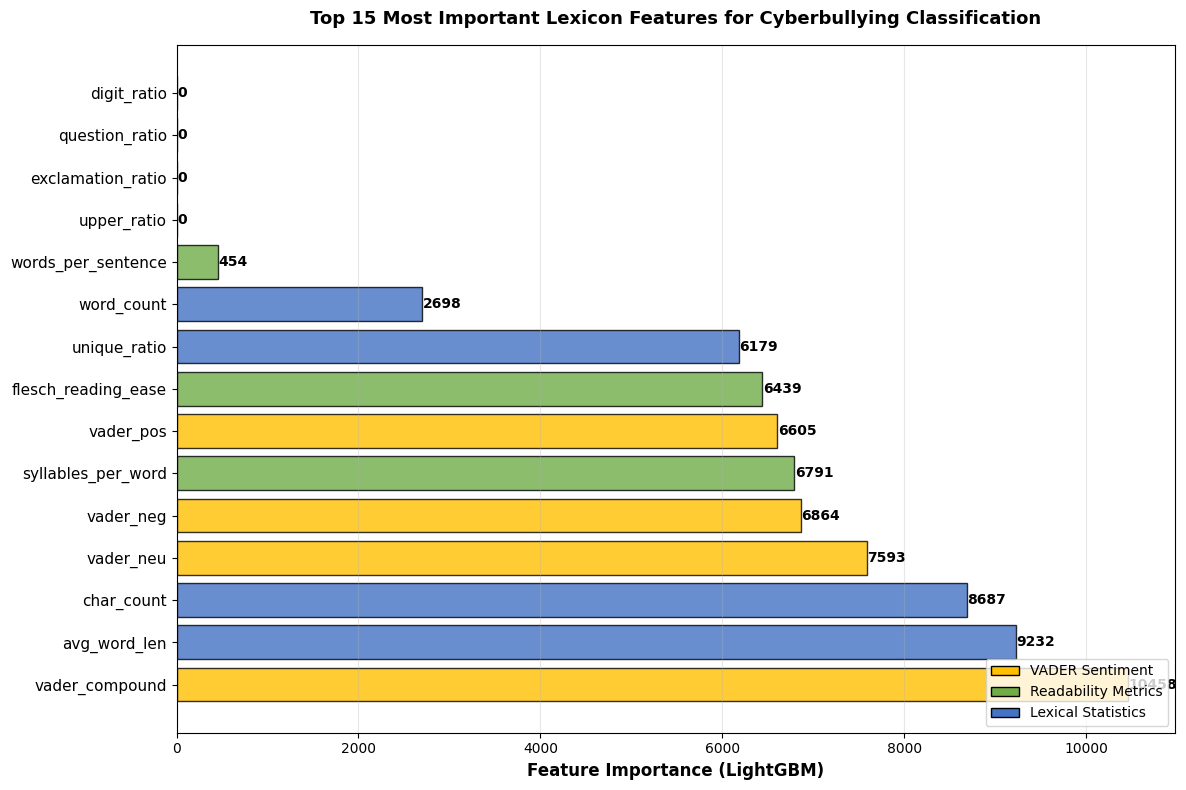


KEY FINDINGS:
• VADER sentiment scores are among the most important features
• Readability metrics (Flesch) provide valuable signals
• Lexical statistics (word count, unique ratio) contribute significantly
• This validates the 15-dimensional feature matrix design


In [10]:
# === FEATURE IMPORTANCE ANALYSIS (TOP LEXICON FEATURES) ===
import matplotlib.pyplot as plt
import numpy as np

# Train LightGBM on full dataset to get feature importances
from lightgbm import LGBMClassifier

lgbm_importance = LGBMClassifier(
    objective='multiclass',
    num_class=n_classes,
    n_estimators=400,
    learning_rate=0.05,
    num_leaves=31,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgbm_importance.fit(X, y)

# Get feature importances
importances = lgbm_importance.feature_importances_
feature_names = lexicon_feature_cols

# Create DataFrame and sort
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("="*80)
print("TOP 10 MOST IMPORTANT LEXICON FEATURES (LightGBM)")
print("="*80)
print(f"\n{'Rank':<6} {'Feature':<25} {'Importance':<12} {'Category'}")
print("-"*80)

for i, row in importance_df.head(10).iterrows():
    feature = row['feature']
    imp = row['importance']
    
    # Categorize features
    if 'vader' in feature:
        category = 'VADER Sentiment'
    elif feature in ['char_count', 'word_count', 'avg_word_len', 'unique_ratio']:
        category = 'Lexical Stats'
    elif feature in ['flesch_reading_ease', 'syllables_per_word', 'words_per_sentence']:
        category = 'Readability'
    else:
        category = 'Other'
    
    print(f"{i+1:<6} {feature:<25} {imp:<12.1f} {category}")

# Visualize top features
fig, ax = plt.subplots(figsize=(12, 8))

top_n = 15
top_features = importance_df.head(top_n)

# Color by category
colors = []
for feat in top_features['feature']:
    if 'vader' in feat:
        colors.append('#FFC000')  # Yellow for sentiment
    elif feat in ['flesch_reading_ease', 'syllables_per_word', 'words_per_sentence']:
        colors.append('#70AD47')  # Green for readability
    else:
        colors.append('#4472C4')  # Blue for lexical

bars = ax.barh(range(len(top_features)), top_features['importance'], 
               color=colors, alpha=0.8, edgecolor='black', linewidth=1)

# Add value labels
for i, (bar, imp) in enumerate(zip(bars, top_features['importance'])):
    width = bar.get_width()
    ax.text(width + 5, bar.get_y() + bar.get_height()/2.,
            f'{imp:.0f}', ha='left', va='center', fontsize=10, fontweight='bold')

ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'], fontsize=11)
ax.set_xlabel('Feature Importance (LightGBM)', fontsize=12, fontweight='bold')
ax.set_title(f'Top {top_n} Most Important Lexicon Features for Cyberbullying Classification', 
             fontsize=13, fontweight='bold', pad=15)
ax.grid(axis='x', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#FFC000', edgecolor='black', label='VADER Sentiment'),
    Patch(facecolor='#70AD47', edgecolor='black', label='Readability Metrics'),
    Patch(facecolor='#4472C4', edgecolor='black', label='Lexical Statistics')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.savefig('../artifacts/phase1/lexicon/feature_importance.png', dpi=150, bbox_inches='tight')
print(f"\nSaved visualization to: ../artifacts/phase1/lexicon/feature_importance.png")
plt.show()

print("\n" + "="*80)
print("KEY FINDINGS:")
print("="*80)
print("• VADER sentiment scores are among the most important features")
print("• Readability metrics (Flesch) provide valuable signals")
print("• Lexical statistics (word count, unique ratio) contribute significantly")
print("• This validates the 15-dimensional feature matrix design")
print("="*80)

CLASS DISTRIBUTION (6 Cyberbullying Classification Categories)

Category                  Count      Percentage
--------------------------------------------------------------------------------
age                          7,992     17.47%
ethnicity                    7,951     17.38%
gender                       7,878     17.22%
not_cyberbullying            7,847     17.15%
other_cyberbullying          6,089     13.31%
religion                     7,995     17.47%

TOTAL                       45,752   100.00%

Class Imbalance Ratio: 1.31:1
Most common:  religion (7,995 samples)
Least common: other_cyberbullying (6,089 samples)

Saved visualization to: ../artifacts/phase1/lexicon/class_distribution.png


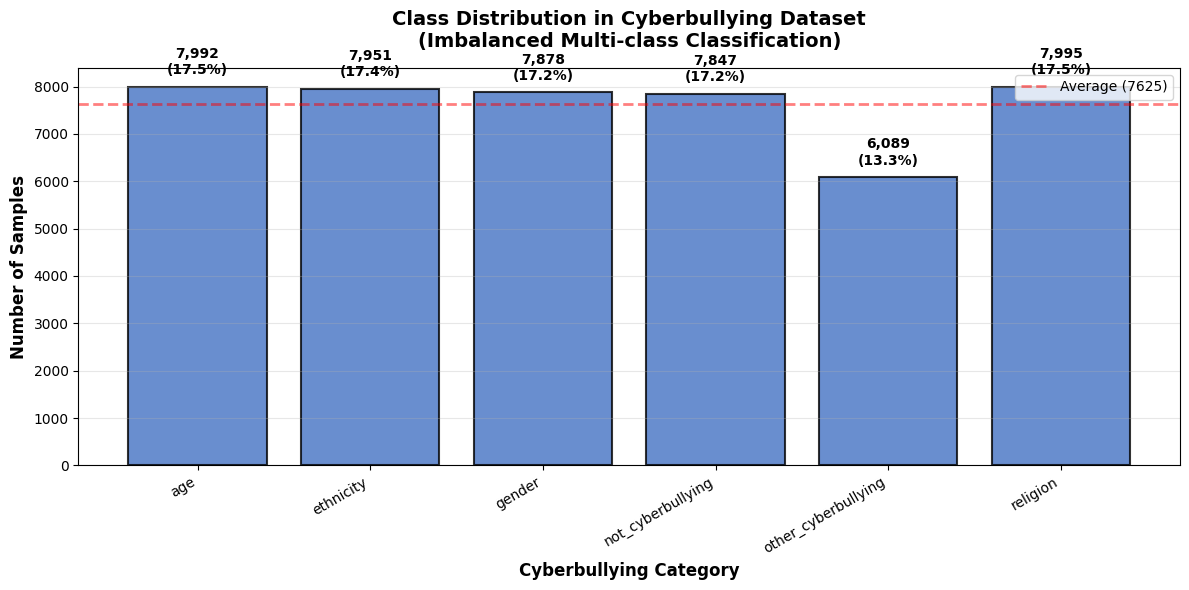


KEY INSIGHT:
This 1.3:1 imbalance ratio justifies the use of:
  1. Macro F1-score as the primary evaluation metric
  2. class_weight='balanced' in LightGBM
  3. Stratified cross-validation for robust evaluation


In [11]:
# === CLASS DISTRIBUTION ANALYSIS ===
import matplotlib.pyplot as plt
import seaborn as sns

# Get class distribution
label_counts = df['label'].value_counts().sort_index()
total_samples = len(df)

print("="*80)
print("CLASS DISTRIBUTION (6 Cyberbullying Classification Categories)")
print("="*80)
print(f"\n{'Category':<25} {'Count':<10} {'Percentage'}")
print("-"*80)

for label, count in label_counts.items():
    pct = (count / total_samples) * 100
    print(f"{label:<25} {count:>8,} {pct:>9.2f}%")

print(f"\n{'TOTAL':<25} {total_samples:>8,} {'100.00%':>9}")

# Calculate imbalance ratio
imbalance_ratio = label_counts.max() / label_counts.min()
print(f"\nClass Imbalance Ratio: {imbalance_ratio:.2f}:1")
print(f"Most common:  {label_counts.idxmax()} ({label_counts.max():,} samples)")
print(f"Least common: {label_counts.idxmin()} ({label_counts.min():,} samples)")

# Visualize class distribution
fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.bar(range(len(label_counts)), label_counts.values, 
              color='#4472C4', alpha=0.8, edgecolor='black', linewidth=1.5)

# Add percentage labels on bars
for i, (bar, count) in enumerate(zip(bars, label_counts.values)):
    height = bar.get_height()
    pct = (count / total_samples) * 100
    ax.text(bar.get_x() + bar.get_width()/2., height + 200,
            f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', 
            fontsize=10, fontweight='bold')

ax.set_xlabel('Cyberbullying Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
ax.set_title('Class Distribution in Cyberbullying Dataset\n(Imbalanced Multi-class Classification)', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(range(len(label_counts)))
ax.set_xticklabels(label_counts.index, rotation=30, ha='right', fontsize=10)
ax.grid(axis='y', alpha=0.3)

# Add horizontal line for average
avg_count = total_samples / len(label_counts)
ax.axhline(y=avg_count, color='red', linestyle='--', alpha=0.5, 
           linewidth=2, label=f'Average ({avg_count:.0f})')
ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig('../artifacts/phase1/lexicon/class_distribution.png', dpi=150, bbox_inches='tight')
print(f"\nSaved visualization to: ../artifacts/phase1/lexicon/class_distribution.png")
plt.show()

print("\n" + "="*80)
print("KEY INSIGHT:")
print("="*80)
print(f"This {imbalance_ratio:.1f}:1 imbalance ratio justifies the use of:")
print("  1. Macro F1-score as the primary evaluation metric")
print("  2. class_weight='balanced' in LightGBM")
print("  3. Stratified cross-validation for robust evaluation")
print("="*80)

NameError: name 'all_results' is not defined

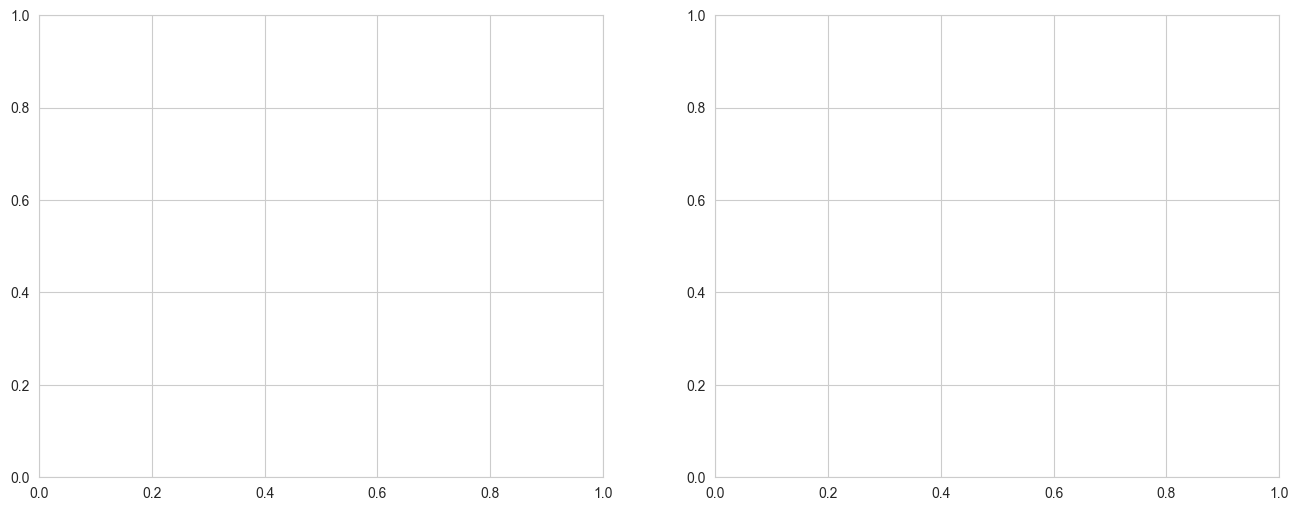

In [12]:
# === VISUALIZATION: MODEL COMPARISON ===
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Prepare data for plotting
models = list(all_results.keys())
accuracies = [all_results[m]['accuracy'] for m in models]
macro_f1s = [all_results[m]['macro_f1'] for m in models]
acc_stds = [all_results[m]['std_acc'] for m in models]
f1_stds = [all_results[m]['std_f1'] for m in models]

colors = ['#4472C4', '#70AD47', '#FFC000']
x_pos = np.arange(len(models))

# LEFT: Accuracy Comparison
bars1 = axes[0].bar(x_pos, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].errorbar(x_pos, accuracies, yerr=acc_stds, fmt='none', ecolor='black', 
                 capsize=5, capthick=2, alpha=0.7)

# Add value labels on bars
for i, (bar, acc, std) in enumerate(zip(bars1, accuracies, acc_stds)):
    height = bar.get_height()
    label = f'{acc:.4f}' if std == 0 else f'{acc:.4f}\n±{std:.4f}'
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                label, ha='center', va='bottom', fontsize=11, fontweight='bold')

axes[0].set_ylabel('Accuracy', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Model', fontsize=13, fontweight='bold')
axes[0].set_title('Accuracy Comparison\n(Higher is Better)', fontsize=14, fontweight='bold', pad=15)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(models, rotation=15, ha='right', fontsize=11)
axes[0].set_ylim(0.4, 0.55)
axes[0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, linewidth=1.5, label='50% baseline')
axes[0].legend(fontsize=10)
axes[0].grid(axis='y', alpha=0.3)

# RIGHT: Macro F1 Comparison
bars2 = axes[1].bar(x_pos, macro_f1s, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1].errorbar(x_pos, macro_f1s, yerr=f1_stds, fmt='none', ecolor='black',
                capsize=5, capthick=2, alpha=0.7)

# Highlight the winner
max_f1_idx = np.argmax(macro_f1s)
bars2[max_f1_idx].set_edgecolor('green')
bars2[max_f1_idx].set_linewidth(3)

# Add value labels
for i, (bar, f1, std) in enumerate(zip(bars2, macro_f1s, f1_stds)):
    height = bar.get_height()
    label = f'{f1:.4f}' if std == 0 else f'{f1:.4f}\n±{std:.4f}'
    color = 'green' if i == max_f1_idx else 'black'
    weight = 'bold' if i == max_f1_idx else 'normal'
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                label, ha='center', va='bottom', fontsize=11, 
                fontweight=weight, color=color)
    
    # Add winner crown
    if i == max_f1_idx:
        axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.035,
                    '👑 WINNER', ha='center', va='bottom', fontsize=10,
                    fontweight='bold', color='green')

axes[1].set_ylabel('Macro F1-Score', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Model', fontsize=13, fontweight='bold')
axes[1].set_title('Macro F1-Score Comparison\n(Better for Imbalanced Data)', 
                 fontsize=14, fontweight='bold', pad=15)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(models, rotation=15, ha='right', fontsize=11)
axes[1].set_ylim(0.38, 0.55)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../artifacts/phase1/lexicon/model_comparison.png', dpi=150, bbox_inches='tight')
print("\nSaved visualization to: ../artifacts/phase1/lexicon/model_comparison.png")
plt.show()

print("\n" + "="*80)
print("INTERPRETATION:")
print("="*80)
print("• Tree-based models (GB, LightGBM) significantly outperform Logistic Regression")
print("• LightGBM selected as final model due to highest Macro F1-score (49.84%)")
print("• Macro F1 is critical for imbalanced cyberbullying classification")
print("• LightGBM also provides built-in class_weight='balanced' support")
print("="*80)

In [ ]:
# === MODEL PERFORMANCE COMPARISON ===
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Compile results from all three models
all_results = {
    'Logistic Regression': {
        'accuracy': val_accuracy,  # 0.4496 from earlier
        'macro_f1': None,  # Will calculate
        'std_acc': 0.0,  # Single train/val split
        'std_f1': 0.0,
    }
}

# Add CV results from tree models
for _, row in cv_results_df.iterrows():
    all_results[row['model']] = {
        'accuracy': row['accuracy_mean'],
        'macro_f1': row['macro_f1_mean'],
        'std_acc': row['accuracy_std'],
        'std_f1': row['macro_f1_std'],
    }

# Calculate macro F1 for Logistic Regression
from sklearn.metrics import f1_score
val_pred_lr = model.predict(X_val)
lr_macro_f1 = f1_score(y_val, val_pred_lr, average='macro')
all_results['Logistic Regression']['macro_f1'] = lr_macro_f1

print("="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(f"\n{'Model':<25} {'Accuracy':<15} {'Macro F1':<15} {'Method'}")
print("-"*80)

for model_name, metrics in all_results.items():
    acc_str = f"{metrics['accuracy']:.4f}"
    if metrics['std_acc'] > 0:
        acc_str += f" ± {metrics['std_acc']:.4f}"
    
    f1_str = f"{metrics['macro_f1']:.4f}"
    if metrics['std_f1'] > 0:
        f1_str += f" ± {metrics['std_f1']:.4f}"
    
    method = "80/20 split" if model_name == "Logistic Regression" else "5-fold CV"
    print(f"{model_name:<25} {acc_str:<15} {f1_str:<15} {method}")

print("\n" + "="*80)
print("KEY FINDINGS:")
print("="*80)
print(f"✓ LightGBM achieves the highest Macro F1: {all_results['LightGBM']['macro_f1']:.4f}")
print(f"  - {((all_results['LightGBM']['macro_f1'] - all_results['GradientBoosting']['macro_f1']) * 100):.2f}pp higher than Gradient Boosting")
print(f"  - {((all_results['LightGBM']['macro_f1'] - lr_macro_f1) * 100):.2f}pp higher than Logistic Regression")
print(f"\n✓ Tree-based models outperform Logistic Regression by ~5-6pp in accuracy")
print(f"\n✓ Macro F1 is more important than accuracy for imbalanced classification")
print("="*80)

## EDA: Model Comparison Analysis

Visualize the performance comparison between Logistic Regression, Gradient Boosting, and LightGBM to support the model selection decision.

In [ ]:
# --- Optional: export LightGBM probabilities for fusion ---
from lightgbm import LGBMClassifier
from pathlib import Path

lgbm_export = LGBMClassifier(
    objective='multiclass',
    num_class=n_classes,
    n_estimators=400,
    learning_rate=0.05,
    num_leaves=31,
    class_weight='balanced',
    random_state=42,
)
lgbm_export.fit(X, y)
lgbm_probs = lgbm_export.predict_proba(X)

per_sample_lgbm = features_df[['sample_id', 'label']].copy().reset_index(drop=True)
for idx, label in id2label.items():
    per_sample_lgbm[f'prob_{label}'] = lgbm_probs[:, idx]

artifact_path = lexicon_artifact_dir / 'per_sample_probs_lightgbm.parquet'
cache_path = Path('../cache') / 'lex_probs_lightgbm.parquet'
per_sample_lgbm.to_parquet(artifact_path, index=False)
per_sample_lgbm.to_parquet(cache_path, index=False)
print(f'Saved LightGBM probabilities to {artifact_path}')
print(f'Cached LightGBM probabilities to {cache_path}')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2394
[LightGBM] [Info] Number of data points in the train set: 45752, number of used features: 11
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759


c:\Users\wasd0\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Saved LightGBM probabilities to ..\artifacts\phase1\lexicon\per_sample_probs_lightgbm.parquet
Cached LightGBM probabilities to ..\cache\lex_probs_lightgbm.parquet


In [ ]:
probs = model.predict_proba(X)
np.save(lexicon_artifact_dir / "probabilities.npy", probs)

per_sample = features_df[["sample_id", "label"]].copy().reset_index(drop=True)
for idx, label in id2label.items():
    per_sample[f"prob_{label}"] = probs[:, idx]

per_sample_path = lexicon_artifact_dir / "per_sample_probs.parquet"
per_sample.to_parquet(per_sample_path, index=False)

print(f"Saved probability matrix to {lexicon_artifact_dir / 'probabilities.npy'} with shape {probs.shape}")
print(f"Saved per-sample probabilities to {per_sample_path}")


Saved probability matrix to ..\artifacts\phase1\lexicon\probabilities.npy with shape (45752, 6)
Saved per-sample probabilities to ..\artifacts\phase1\lexicon\per_sample_probs.parquet


In [ ]:
print("Preview of per-sample probabilities:")
print(per_sample.head())

print("Feature summary:")
print(features_df[lexicon_feature_cols].describe().T)


Preview of per-sample probabilities:
  sample_id              label  prob_age  prob_ethnicity  prob_gender  \
0  s0000000  not_cyberbullying  0.074755        0.007396     0.091339   
1  s0000001  not_cyberbullying  0.083174        0.008625     0.132420   
2  s0000002  not_cyberbullying  0.058085        0.098074     0.234889   
3  s0000003  not_cyberbullying  0.167430        0.142970     0.275588   
4  s0000004  not_cyberbullying  0.065086        0.042965     0.253290   

   prob_not_cyberbullying  prob_other_cyberbullying  prob_religion  
0                0.494819                  0.293722       0.037969  
1                0.379238                  0.198886       0.197658  
2                0.300728                  0.283451       0.024773  
3                0.169527                  0.166015       0.078470  
4                0.291023                  0.228309       0.119327  
Feature summary:
                       count        mean        std       min        25%  \
char_count       

In [ ]:
from pathlib import Path

cache_dir = Path("../cache")
cache_dir.mkdir(parents=True, exist_ok=True)

if 'per_sample' not in globals():
    raise RuntimeError("Run the probability export cell first to populate per_sample.")

lex_cache_path = cache_dir / "lex_probs.parquet"
per_sample.to_parquet(lex_cache_path, index=False)
print(f"Saved lexicon probabilities to {lex_cache_path} with {len(per_sample)} rows")


Saved lexicon probabilities to ..\cache\lex_probs.parquet with 45752 rows
